## Comparing Metrics for Cahn-Hilliard Simulations

...


_Library imports. To install, run `import Pkg; Pkg.add([PACKAGE_NAME])`, or add directly in `Pkg` in the `Julia` command line._

In [1]:
using Distributions
using Plots
using StatsPlots
using Printf
using ProgressBars

Additional requirements from `demixing_2d.jl`:
- `FFTW` : Fast Fourier transform library
- `DelimitedFiles` : For saving, loading as csv
- `PyCall` : Run Python in Julia, needed for `np.bincount()`

Optionally,
- `ForwardDiff` : For checking implementations

In [2]:
## Main source code
include("../src/CahnHilliard.jl/demixing_2d.jl")

verify_numerics (generic function with 1 method)

### Problem: solve for $\varphi(\mathbf{x},t)$

$$
    \frac{\mathrm{d}}{\mathrm{d}t}\varphi(\mathbf{x},t) = M\nabla^2\frac{\mathrm{d}}{\mathrm{d}\varphi}F(\varphi),
$$

where
$$
\frac{\mathrm{d}}{\mathrm{d}\varphi}F(\varphi) \approx -\alpha\varphi + \beta\varphi^3 + \kappa\nabla^2\varphi
$$

#### Solution: finite difference scheme
Discretise $\mathbf{x}_m = \{j\delta_x^{-1}\,|\,j=0,\ldots,1\} \times \{j\delta_x^{-1}\,|\,j=0,\ldots,1\}$, and $t_m = \{k\delta_t^{-1}\,|\,j=0,\ldots,T\}$:

$$
        \mu_k = -\alpha\varphi_{k-1} + \beta\varphi_{k-1}^3 + \kappa\tilde{\nabla}^2(\varphi_{k-1},\delta_x)
$$

$$
        \varphi_k = \varphi_{k-1} + \delta_tM\tilde{\nabla}^2(\mu_k,\delta_x),
$$
where $\varphi_k \approx \varphi(\mathbf{x}_m,t_m[k])$, $\mu_k \approx \mathrm{d}F/\mathrm{d}\varphi_k$ and
$$
    \tilde{\nabla}^2(\phi, \delta)_{i,j} = \frac{\phi_{i,j-1} + \phi_{i-1,j} - 4\phi_{i,j} + \phi_{i,j+1} + \phi_{i+1,j}}{\delta^2}
$$

In [3]:
# Choose α, β, κ
θ = Dict(
    :α => exp(-11.86),
    :β => 1.2e-4,
    :κ => exp(-0.35)
) # α and κ are defined in logspace first because we will use log normal priors later

Dict{Symbol,Float64} with 3 entries:
  :α => 7.06753e-6
  :κ => 0.704688
  :β => 0.00012

In [4]:
# Fix number of iterations (T*δₜ)
num_iterations = 10000

# Construct parameter struct
params = generate_params(θ)
display(params)

# Initialise φ
ϕ,μ = initialise(params)
ϕ₀ = copy(ϕ)

# Diffuse iteratively
for i ∈ 1:num_iterations
    # Update μ
    calculate_μ!(μ, ϕ, params)
    # Iterate φ
    diffuse_ϕ!(ϕ, μ, params)
    
    # Crude progress indicator
    write(stdout, @sprintf("\r%5d/%d",i,num_iterations)) |> _ -> flush(stdout)
end

Variables(Dict(:ϕ=>0.2,:t=>1.0e8,:x=>500.0), 0.0, Dict(:α=>7.06753e-6,:κ=>0.704688,:β=>0.00012), 1.0)

10000/10000

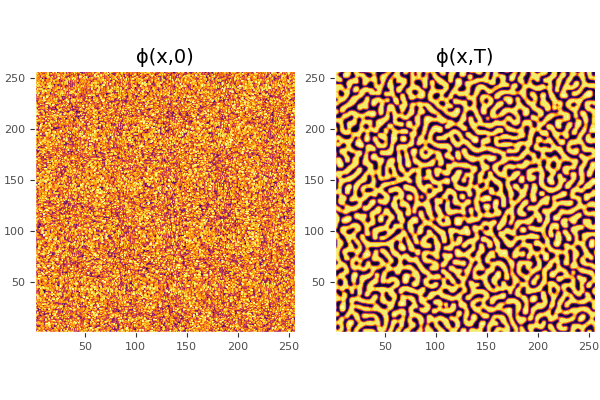

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [5]:
plot(contourf(ϕ₀, aspect_ratio=:equal, title="ϕ(x,0)"), contourf(ϕ, aspect_ratio=:equal, title="ϕ(x,T)"), layout=(1,2), colorbar=:none)

### Scattering Plots

...

In [6]:
ts, q, S = run_simulation(params=θ)

([0, 1250, 2500, 3750, 5000, 6250, 7500, 8750, 10000], [5.54594e-6, 1.036e-5, 1.73831e-5, 2.41543e-5, 3.2246e-5, 4.0492e-5, 4.7957e-5, 5.55211e-5, 6.29192e-5, 7.11634e-5  …  0.00134809, 0.00135612, 0.0013644, 0.0013724, 0.00138073, 0.00138853, 0.00139545, 0.00140223, 0.00140868, 0.00141421], [8.52864 8.5608 … 8.74666 8.75964; 16.4374 16.5498 … 16.8225 16.834; … ; 10.7609 0.324402 … 1.26735 1.44717; 10.7071 0.374061 … 0.494877 0.949396])

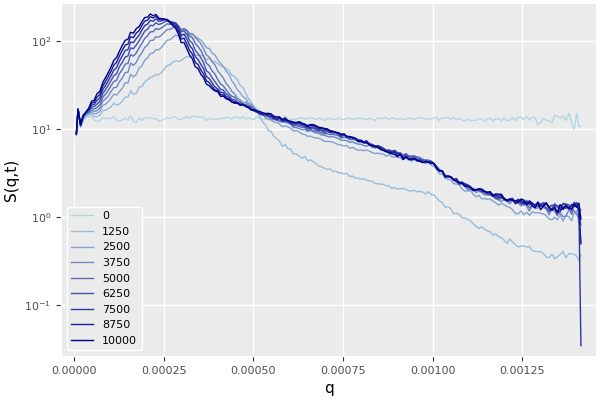

In [7]:
p = plot(yscale=:log, xlabel="q", ylabel="S(q,t)")
cmap = cgrad(:blues) |> (g-> RGB[g[z] for z in range(0,1,length=length(ts))])
for (i,t) ∈ enumerate(ts)
    plot!(p, q, S[:,i], label=t, line=(1., 1., cmap[i]))
end
p

## Quantifying uncertainty

...

### Experimental uncertainty

Fixing the parameters and trying different instantiations of $\varphi_0$

In [8]:
# Choose α, β, κ
θ = Dict(
    :α => exp(-11.86),
    :β => 1.2e-4,
    :κ => exp(-0.35)
) # α and κ are defined in logspace first because we will use log normal priors later

ts, q, Ss = generate_samples(30; params=θ);

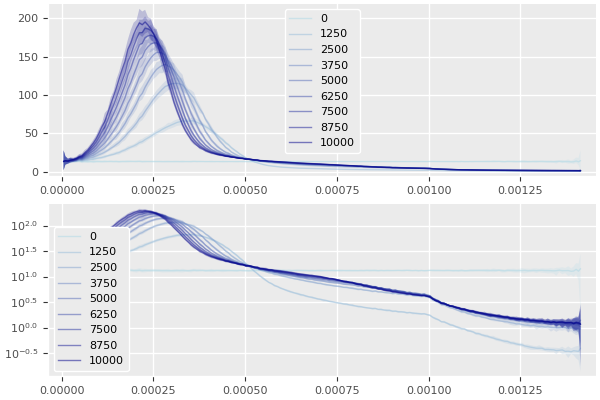

In [9]:
plot(plot_err(ts, q, Ss, yscale=:none), plot_err(ts, q, Ss), layout=(2,1))

#### Propagating uncertainty from parameter choice

Choose priors for $\alpha$, $\beta$, and $\kappa$, with constraints that $\alpha,\kappa > 0$.

$$
    p(\mathbf{\theta}) = p(\alpha)p(\beta)p(\kappa)
$$

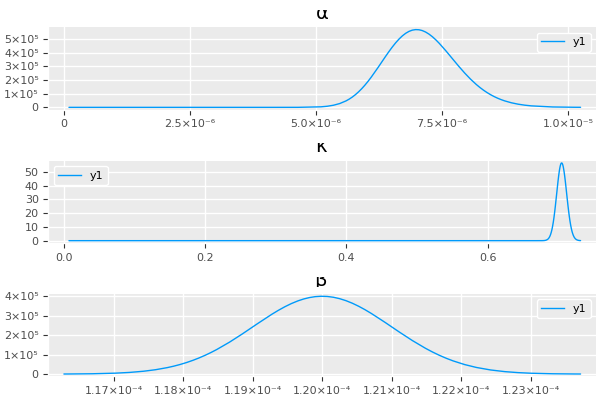

In [10]:
p_of_α = LogNormal(-11.86, 0.1)
p_of_β = Normal(1.2e-4, 1e-6)
p_of_κ = LogNormal(-0.35, 0.01)

p_of_θ = Dict(
    :α => p_of_α,
    :β => p_of_β,
    :κ => p_of_κ
)

plot([plot(v, title=k) for (k,v) ∈ p_of_θ]..., layout=(3,1))

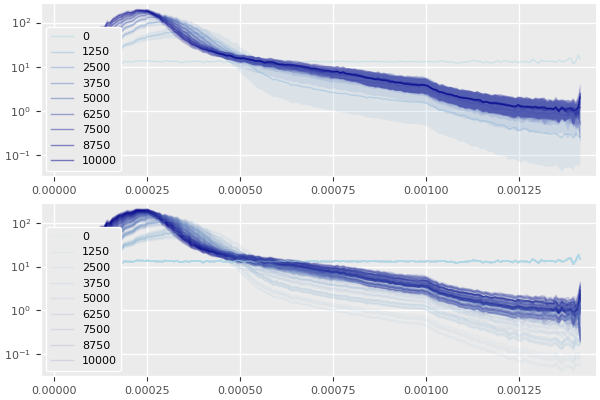

In [11]:
ts, q, Ss = generate_samples(30; params=p_of_θ, seed=10);
plot(plot_err(ts, q, Ss), plot_samples(ts, q, Ss), layout=(2,1))

#### Joint uncertainty

Sample from priors and initial conditions

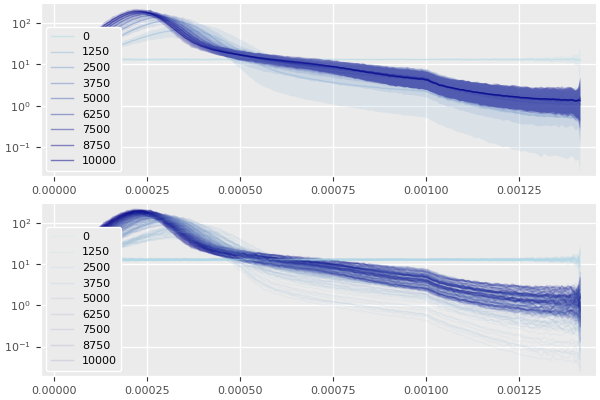

In [12]:
ts, q, Ss = generate_samples(30; params=p_of_θ);
plot(plot_err(ts, q, Ss), plot_samples(ts, q, Ss), layout=(2,1))

---


## Scoring similarity


In [13]:
# Choose α, β, κ
θ = Dict(
    :α => exp(-11.86),
    :β => 1.2e-4,
    :κ => exp(-0.35)
) # α and κ are defined in logspace first because we will use log normal priors later

display(θ)

y = generate_samples(1; params=θ) # a sample from true θ

#true_samples = generate_samples(30; params=θ) # samples from the same θ with different initialisations

samples_α = [generate_samples(30; params= Dict(:α => exp(-11.86 - 0.2*i), :β => 1.2e-4, :κ => exp(-0.35))) for i ∈ -4:6]

Dict{Symbol,Float64} with 3 entries:
  :α => 7.06753e-6
  :κ => 0.704688
  :β => 0.00012

11-element Array{Tuple{Array{Int64,1},Array{Float64,1},Array{Any,1}},1}:
 ([0, 1250, 2500, 3750, 5000, 6250, 7500, 8750, 10000], [5.54594e-6, 1.036e-5, 1.73831e-5, 2.41543e-5, 3.2246e-5, 4.0492e-5, 4.7957e-5, 5.55211e-5, 6.29192e-5, 7.11634e-5  …  0.00134809, 0.00135612, 0.0013644, 0.0013724, 0.00138073, 0.00138853, 0.00139545, 0.00140223, 0.00140868, 0.00141421], [[24.4924 24.5451 … 24.0617 24.0474; 14.3041 14.4845 … 14.9695 15.0524; … ; 11.817 9.77084 … 8.35599 8.9101; 25.4633 3.31187 … 9.2871 10.7194], [14.1386 14.3277 … 14.5702 14.5942; 15.6588 15.8115 … 16.5622 16.822; … ; 15.5196 7.45765 … 11.2064 10.0016; 10.1568 4.78676 … 9.90197 8.10461], [9.92116 9.95339 … 10.5524 10.691; 10.487 10.6015 … 11.0263 11.134; … ; 13.7294 10.1151 … 6.94269 7.85132; 19.5689 4.33926 … 20.3998 20.5659], [4.26713 4.19243 … 4.40441 4.42153; 17.782 17.8929 … 18.4462 18.555; … ; 12.4868 10.8603 … 9.39589 8.26005; 7.41594 7.91705 … 15.3321 9.45324], [11.5593 11.6173 … 11.4749 11.4295; 15.447 15.627 … 16.19

### Calculate scores for samples

Compute mean-square error with $y$ for each of the sample solutions for the different values of $\alpha$ for full plots:

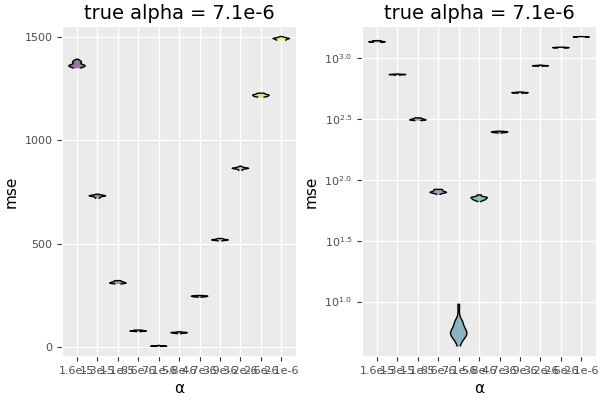

In [60]:
ℓ_θs = [calculate_loss(y, samples, metric=mse) for samples ∈ samples_α]

cmap = cgrad(:viridis) |> (g-> RGB[g[z] for z in range(0,1,length=length(samples_α))])

p = plot(
    xticks=(
        collect(1:length(ℓ_θs)),
        round.(exp.(-11.86.-0.2.*collect(-4:6)),sigdigits=2) .|> string
    ),
    xlabel="α", ylabel="mse",
    #yscale=:log,
    title="true alpha = "*string(round.(θ[:α],sigdigits=2)))

[violin!(p, [j], [ℓ_θs[j]...], fillcolor=cmap[j], fillalpha=0.5, label="") for (j,i) ∈ enumerate(-4:6)]

p

p2 = deepcopy(p)
plot!(p2, yscale=:log)
plot(p,p2,layout=(1,2))

Observing that lowest scores ($<10$) are when $\alpha = \tilde{\alpha}$, the true value, and errors grow approximately quadratically with $|\alpha - \tilde{\alpha}|$.